<a href="https://colab.research.google.com/github/ibonetc/DataAnalytics_Text/blob/master/DA_Anal_Sentimientos_snscrape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de sentimientos
Existen dos formas clásicas de hacer análisis de sentimientos:

* Enfoque basado en tokens: A partir de un diccionario de palabras positivas, negativas y neutrales, se cuentan la cantidad de palabras positivas y negativas en el texto y se determina el sentimiento del texto como la cantidad que prevalece.

* Enfoque basado en aprendizaje automático: a partir de una base de conocimientos con datos preetiquetados en  positivo, negativo y neutral, se entrena un modelo de aprendizaje automático para clasificar el texto.

El análisis de sentimientos es una forma de evaluar lo que se dice en un texto sobre un tema determinado. Se puntúa utilizando valores de polaridad que van de 1 a -1. Los valores más cercanos a 1 indican más positividad, mientras que los valores más cercanos a -1 indican más negatividad.

In [ ]:
!pip install snscrape

In [ ]:
!pip install boto3

     |████████████████████████████████| 132 kB 26.3 MB/s 
     |████████████████████████████████| 8.6 MB 36.8 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 138 kB 50.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
#import snscrape.modules.twitter as sntwitter
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import nltk
from textblob import TextBlob
import re

In [3]:
path='/content/drive/MyDrive/Datasets/'
df=pd.read_csv(path+'SearchRCNTV_.csv', encoding='utf-8-sig')

In [4]:
df.head()

,Unnamed: 0,url,date,content,id,username,outlinks,outlinksss,tcooutlinks,tcooutlinksss
0,0,https://twitter.com/mauronuma/status/155461657...,2022-08-02 18:54:09-05:00,@pulzo @petrogustavo Perdón @MauricioLizcano n...,1554616573301665792,mauronuma,[],NaN,[],NaN
1,1,https://twitter.com/AltairPR/status/1554616085...,2022-08-02 18:52:12-05:00,@TVCritica2017 @BlogRumoreS @CanalRCN @Telemun...,1554616085609078784,AltairPR,[],NaN,[],NaN
2,2,https://twitter.com/AltairPR/status/1554615783...,2022-08-02 18:51:00-05:00,@TVCritica2017 @BlogRumoreS @CanalRCN @Telemun...,1554615783036272640,AltairPR,[],NaN,[],NaN
3,3,https://twitter.com/mcardonarene/status/155461...,2022-08-02 18:48:44-05:00,@TVCritica2017 @BlogRumoreS @CanalRCN @Telemun...,1554615211725934594,mcardonarene,[],NaN,[],NaN
4,4,https://twitter.com/MaiteBowen/status/15546142...,2022-08-02 18:44:54-05:00,Avance de #factorx en las noches por #CanalRC...,1554614248063606790,MaiteBowen,[],NaN,[],NaN


Podemos hacer una limpieza de texto sin quitar signos de puntuación todavía, ni stopWords

In [5]:
def  clean_text(df, text_field,new_text_field):
  patternURLEMAIL=r'(\w+[.]?\w+@(\w+\.)+\w+)|((http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?\w+([\-\.]{1}\w+)*\.[a-z]{2,5}(\/)?(([^\s@])*(\/)?)*)'
  patternHashtagMention=r'(@\w+)|(#\w+)'
  #Primero convertimos a minúscula
  df[new_text_field] = df[text_field].str.lower()
  # Utilizamos las expresiones regulares anteriores sobre URL, email, hashtag y menciones para quitarlos
  df[new_text_field] = df[new_text_field].apply(lambda elem: re.sub(patternURLEMAIL,'', elem))  
  # Utilizamos una expresión regular para eliminar los hashtag y las menciones con @
  df[new_text_field] = df[new_text_field].apply(lambda elem: re.sub(patternHashtagMention,'', elem))
  # Utilizamos una expresión regular también para eliminar los números
  df[new_text_field] = df[new_text_field].apply(lambda elem: re.sub(r'\d+','', elem))
  df[new_text_field] = df[new_text_field].apply(lambda elem: re.sub(r'[|]','', elem))
  ## Sustituir espacios de más
  df[new_text_field] = df[new_text_field].apply(lambda elem: re.sub(r'\s+',' ', elem))
  ## Eliminar signos de puntuación '[!#?,.:";]'
  #df[text_field] = df[text_field].apply(lambda elem: re.sub(r'[!#?,.:";‘’]',' ', elem))
  return df

In [23]:
df_clean=clean_text(df.copy(),'content','tweet')

In [24]:
df_clean[['content','tweet']]

,content,tweet
0,@pulzo @petrogustavo Perdón @MauricioLizcano n...,perdón no fue el mismo q hizo botar a del por...
1,@TVCritica2017 @BlogRumoreS @CanalRCN @Telemun...,"ya habían hecho un refrito, ¿no?"
2,@TVCritica2017 @BlogRumoreS @CanalRCN @Telemun...,nunca pude ver esa novela. dicen que es buení...
3,@TVCritica2017 @BlogRumoreS @CanalRCN @Telemun...,y todos unos fiascos.
4,Avance de #factorx en las noches por #CanalRC...,avance de en las noches por .
...,...,...
4995,@CanalRCN @carogomezfilm Carito me habla en in...,carito me habla en ingles!!!
4996,@Julian_factorx Para mi si están en la final. ...,para mi si están en la final. mis finalistas ...
4997,@chalolinares @CanalRCN A excepción de Isabell...,"a excepción de isabella, pero aun así fué una..."
4998,Pueden darnos más hate o darnos amor en nuestr...,pueden darnos más hate o darnos amor en nuestr...


Quitemos los emojis

In [8]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 4.3 MB/s 
  Created wheel for emoji: filename=emoji-2.0.0-py3-none-any.whl size=193022 sha256=0c1f327e89dc67854d0a25deaa2210801d6eafc0b9364302f0a3a40ddf62a1a4
  Stored in directory: /root/.cache/pip/wheels/ec/29/4d/3cfe7452ac7d8d83b1930f8a6205c3c9649b24e80f9029fc38
Successfully built emoji


In [9]:
import emoji

Guardemos una columna con los emojis convertidos a texto

In [10]:
df_clean['tweet_wE']=df_clean['tweet'].apply(lambda text: emoji.demojize(text,language='es'))

In [11]:
df_clean['tweet']=df_clean['tweet'].apply(lambda text: emoji.replace_emoji(text,''))

In [12]:
df_clean['tweet']=df_clean['tweet'].apply(lambda elem: re.sub(r'[/]','', elem))

In [13]:
df_clean['tweet']=df_clean['tweet'].apply(lambda elem: re.sub(r'\s+',' ', elem))
df_clean['tweet']=df_clean['tweet'].apply(lambda elem: re.sub(r'^\s+|\s+$','', elem))

In [14]:
df_clean['tweet'][0]

'perdón no fue el mismo q hizo botar a del por una investigación sobre volteo de tierras y por adueñarse de unos terrenos en el eje cafetero cuando fue senador del partido de la u y fue el jefe del empalme. no me crean tan toche.'

In [15]:
analysis=TextBlob(df_clean['tweet'][0])

In [16]:
s=TextBlob('This is wrong')
s.sentiment

Sentiment(polarity=-0.5, subjectivity=0.9)

In [17]:
s=TextBlob('Esto está muy mal')
s.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

En estos momentos la función de detección de idioma y de traducción no está funcionando

## Uso de AWS con Comprehend

### Configuración de API y conección

Primero hay que crear un fichero con la configuración de las claves de uusario de AWS.

Crear un usuario en el servicio IAM, crearle una clave de acceso, se puede descagar el fichero .csv o copiar la clave desde ahí.

Crear un fichero .txt con esta estructura:

[default]

aws_access_key_id=

aws_secret_access_key=

[Referencia:](https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-files.html)

Copiemos el fichero en una carpeta en nuestro Drive, activemos el drive y comencemos:

In [47]:
!mkdir -p ~/.aws &&\
  cp /content/drive/My\ Drive/AWS/credencials.txt ~/.aws/credentials

In [51]:
import boto3
comprehend = boto3.client(service_name='comprehend', region_name="us-east-2")
text = "Este curso es una maravilla. Las clases virtuales también son buenas"
sentiment=comprehend.detect_sentiment(Text=text, LanguageCode='es')
sentiment

{'ResponseMetadata': {'HTTPHeaders': {'content-length': '165',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 03 Aug 2022 20:23:34 GMT',
   'x-amzn-requestid': 'ea9b3a8f-0b25-45b0-87eb-a815a979c82d'},
  'HTTPStatusCode': 200,
  'RequestId': 'ea9b3a8f-0b25-45b0-87eb-a815a979c82d',
  'RetryAttempts': 0},
 'Sentiment': 'POSITIVE',
 'SentimentScore': {'Mixed': 7.289922359632328e-05,
  'Negative': 7.47397934901528e-05,
  'Neutral': 0.0025757814291864634,
  'Positive': 0.9972766041755676}}

In [52]:
sentiment=comprehend.detect_sentiment(Text='😀😁', LanguageCode='es')
print(sentiment)

{'Sentiment': 'NEUTRAL', 'SentimentScore': {'Positive': 0.034072715789079666, 'Negative': 0.004296245984733105, 'Neutral': 0.9427817463874817, 'Mixed': 0.018849296495318413}, 'ResponseMetadata': {'RequestId': '262621ac-4b63-4662-a429-ba925706dfd2', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '262621ac-4b63-4662-a429-ba925706dfd2', 'content-type': 'application/x-amz-json-1.1', 'content-length': '164', 'date': 'Wed, 03 Aug 2022 20:23:39 GMT'}, 'RetryAttempts': 0}}


In [53]:
sentiment=comprehend.detect_sentiment(Text=':-(', LanguageCode='es')
sentiment

{'ResponseMetadata': {'HTTPHeaders': {'content-length': '164',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 03 Aug 2022 20:23:44 GMT',
   'x-amzn-requestid': '4c45169f-e7ff-4094-bcdc-f3be5800ddca'},
  'HTTPStatusCode': 200,
  'RequestId': '4c45169f-e7ff-4094-bcdc-f3be5800ddca',
  'RetryAttempts': 0},
 'Sentiment': 'NEGATIVE',
 'SentimentScore': {'Mixed': 0.09714784473180771,
  'Negative': 0.8399717211723328,
  'Neutral': 0.057301852852106094,
  'Positive': 0.005578585900366306}}

Probar API con un ejemplo sencillo de análisis de sentimientos en una frase.
Para esto usaremos el servicio de Comprehend de AWS 

Como se puede ver en el resultado tenemos el sentimiento y el score para cada uno, entre: Mixto, Negativo, Neutral y Positivo.

In [ ]:
print(sentiment['Sentiment'])
s=sentiment['Sentiment'][0]+sentiment['Sentiment'][1:].lower()
print(s)
sentiment['SentimentScore'][s]

POSITIVE
Positive


0.9972766041755676

In [ ]:
df_clean

,Unnamed: 0,url,date,content,id,username,outlinks,outlinksss,tcooutlinks,tcooutlinksss,tweet,tweet_wE
0,0,https://twitter.com/perlyk21/status/1503499547...,2022-03-14 17:33:20-05:00,@Mag_ECpe 🤦‍♀️🤬! Esta nota es 1 rejunte de inf...,1503499547753914370,perlyk21,[],NaN,[],NaN,! esta nota es rejunte de info mal ensamblada!...,:mujer_con_la_mano_en_la_frente::cara_con_sím...
1,1,https://twitter.com/LocoLlamas/status/15034988...,2022-03-14 17:30:33-05:00,@CanalRCN Quien en su puto sano juicio le tend...,1503498845413593093,LocoLlamas,[],NaN,[],NaN,quien en su puto sano juicio le tendría envidi...,quien en su puto sano juicio le tendría envid...
2,2,https://twitter.com/lucerina57/status/15034985...,2022-03-14 17:29:30-05:00,Falso montaje \n@CanalRCN\n@NoticiasCaracol\n\...,1503498583324213252,lucerina57,['https://www.elespectador.com/politica/elecci...,https://www.elespectador.com/politica/eleccion...,['https://t.co/SuwracX23u'],https://t.co/SuwracX23u,falso montaje,falso montaje
3,3,https://twitter.com/damar59619230/status/15034...,2022-03-14 16:22:48-05:00,@DIJINPolicia @PoliciaCali @FiscaliaCol @RedMa...,1503481795475652619,damar59619230,['https://twitter.com/sirgeorge2603/status/150...,https://twitter.com/sirgeorge2603/status/15034...,['https://t.co/gMqpFbCz2B'],https://t.co/gMqpFbCz2B,deben de detener a este salvaje hp.,deben de detener a este salvaje hp.
4,4,https://twitter.com/Mariafe78094862/status/150...,2022-03-14 15:50:02-05:00,"@CanalRCN Isabella feliz, su arrogancia, su fa...",1503473550245703689,Mariafe78094862,[],NaN,[],NaN,"isabella feliz, su arrogancia, su falta de lid...","isabella feliz, su arrogancia, su falta de li..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,https://twitter.com/SebasJaramillob/status/149...,2022-02-16 11:06:07-05:00,Ole... @BuenDiaColrcn sin las presentadoras es...,1493980016455168004,SebasJaramillob,[],NaN,[],NaN,ole... sin las presentadoras es como aburrido....,ole... sin las presentadoras es como aburrido....
4996,4996,https://twitter.com/juanmurillomuri/status/149...,2022-02-16 10:50:08-05:00,Oigo8gan @NoticiasCaracol y @CanalRCN cuándo ...,1493975996223131651,juanmurillomuri,[],NaN,[],NaN,oigogan y cuándo le piensan contar a colombia ...,oigogan y cuándo le piensan contar a colombia ...
4997,4997,https://twitter.com/alekos0318/status/14939720...,2022-02-16 10:34:37-05:00,Debe andar mal esa audiencia en @CanalRCN para...,1493972091414224899,alekos0318,['https://twitter.com/RICHENAO/status/14937551...,https://twitter.com/RICHENAO/status/1493755109...,['https://t.co/S1VKdw1hIk'],https://t.co/S1VKdw1hIk,debe andar mal esa audiencia en para intentar ...,debe andar mal esa audiencia en para intentar ...
4998,4998,https://twitter.com/CanallaGomez/status/149397...,2022-02-16 10:27:45-05:00,@Margaritarosadf Como raro ni @CaracolTV y muu...,1493970362228514821,CanallaGomez,[],NaN,[],NaN,"como raro ni y muuuucho menos se pronuncian, p...","como raro ni y muuuucho menos se pronuncian, ..."


In [ ]:
comprehend = boto3.client(service_name='comprehend', region_name="us-east-2")
def detect_Sentiment_AWS(comprehend,text):
  if text!='':
    sentiment=comprehend.detect_sentiment(Text=text, LanguageCode='es')
    s=sentiment['Sentiment'][0]+sentiment['Sentiment'][1:].lower()
    return [sentiment['Sentiment'], sentiment['SentimentScore'][s]]
  return ['Neutral',1]

In [ ]:
def detect_Sentiment_AWS(comprehend,text):
  try:
    sentiment=comprehend.detect_sentiment(Text=text, LanguageCode='es')
    s=sentiment['Sentiment'][0]+sentiment['Sentiment'][1:].lower()
    return [sentiment['Sentiment'], sentiment['SentimentScore'][s]]
  except:
    print('error teewt: '+text)
    return ['NEUTRAL',1]

In [ ]:
df_clean['Sent_AWS']=df_clean['tweet'].apply(lambda text: detect_Sentiment_AWS(comprehend,text))

error teewt: 


In [ ]:
df_clean.head()

,Unnamed: 0,url,date,content,id,username,outlinks,outlinksss,tcooutlinks,tcooutlinksss,tweet,tweet_wE,Sent_AWS
0,0,https://twitter.com/perlyk21/status/1503499547...,2022-03-14 17:33:20-05:00,@Mag_ECpe 🤦‍♀️🤬! Esta nota es 1 rejunte de inf...,1503499547753914370,perlyk21,[],NaN,[],NaN,! esta nota es rejunte de info mal ensamblada!...,:mujer_con_la_mano_en_la_frente::cara_con_sím...,"[NEGATIVE, 0.9091576933860779]"
1,1,https://twitter.com/LocoLlamas/status/15034988...,2022-03-14 17:30:33-05:00,@CanalRCN Quien en su puto sano juicio le tend...,1503498845413593093,LocoLlamas,[],NaN,[],NaN,quien en su puto sano juicio le tendría envidi...,quien en su puto sano juicio le tendría envid...,"[NEGATIVE, 0.5002014636993408]"
2,2,https://twitter.com/lucerina57/status/15034985...,2022-03-14 17:29:30-05:00,Falso montaje \n@CanalRCN\n@NoticiasCaracol\n\...,1503498583324213252,lucerina57,['https://www.elespectador.com/politica/elecci...,https://www.elespectador.com/politica/eleccion...,['https://t.co/SuwracX23u'],https://t.co/SuwracX23u,falso montaje,falso montaje,"[NEGATIVE, 0.9992930889129639]"
3,3,https://twitter.com/damar59619230/status/15034...,2022-03-14 16:22:48-05:00,@DIJINPolicia @PoliciaCali @FiscaliaCol @RedMa...,1503481795475652619,damar59619230,['https://twitter.com/sirgeorge2603/status/150...,https://twitter.com/sirgeorge2603/status/15034...,['https://t.co/gMqpFbCz2B'],https://t.co/gMqpFbCz2B,deben de detener a este salvaje hp.,deben de detener a este salvaje hp.,"[NEGATIVE, 0.9159134030342102]"
4,4,https://twitter.com/Mariafe78094862/status/150...,2022-03-14 15:50:02-05:00,"@CanalRCN Isabella feliz, su arrogancia, su fa...",1503473550245703689,Mariafe78094862,[],NaN,[],NaN,"isabella feliz, su arrogancia, su falta de lid...","isabella feliz, su arrogancia, su falta de li...","[NEGATIVE, 0.6544209122657776]"


In [ ]:
# Dividir la columna Sent_AWS
df_clean[['sentimentAWS','polarityAWS']] = pd.DataFrame(df_clean.Sent_AWS.tolist(), index= df_clean.index)

In [ ]:
df_clean.head(50)

In [ ]:
df_clean.sentimentAWS.value_counts()

NEGATIVE    1888
NEUTRAL     1266
POSITIVE     925
MIXED        921
Name: sentimentAWS, dtype: int64

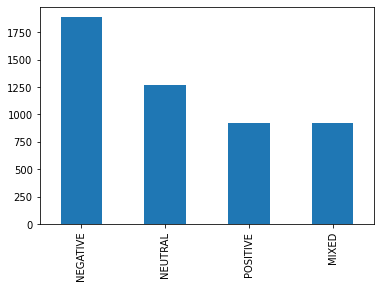

In [ ]:
df_clean.sentimentAWS.value_counts().plot(kind='bar')

In [ ]:
path='/content/drive/My Drive/Analitics_Esp/'
df_clean.to_csv(path+'SearRCNTV_AWS.csv', encoding='utf-8-sig')

In [ ]:
#df_clean=pd.read_csv(path+'SearRCNTV_AWS.csv', encoding='utf-8-sig')

In [ ]:
df_clean[df_clean['sentimentAWS']=='POSITIVE']['tweet']

5                    gracias mi yasmin. un abrazo grande!
6                                               saludos !
7                                                gracias!
10                                               gracias!
13      bueno la verdad que se ve de lo mejor sorprend...
                              ...                        
4938    ta lindo jattin ... es del top cuando va mostr...
4940                               esa hembra es lo mejor
4983    "si como baila cocina, me le como hasta el peg...
4985                                      jajajajajaa más
4988     comienzan los entrenamientos en te la dedico por
Name: tweet, Length: 925, dtype: object


In [ ]:
df_clean[df_clean['sentimentAWS']=='NEGATIVE']['tweet']

0       ! esta nota es rejunte de info mal ensamblada!...
1       quien en su puto sano juicio le tendría envidi...
2                                           falso montaje
3                     deben de detener a este salvaje hp.
4       isabella feliz, su arrogancia, su falta de lid...
                              ...                        
4991    a lo bien prestarle atención a este tema tan r...
4993    no me parece el horario ni los días para hacer...
4995    ole... sin las presentadoras es como aburrido....
4997    debe andar mal esa audiencia en para intentar ...
4998    como raro ni y muuuucho menos se pronuncian, p...
Name: tweet, Length: 1888, dtype: object

In [ ]:
comprehend.detect_dominant_language(Text=text)

{'Languages': [{'LanguageCode': 'es', 'Score': 0.997227132320404}],
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '63',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 16 Mar 2022 19:45:45 GMT',
   'x-amzn-requestid': 'f433ad00-4d62-4d2e-8607-d1bdf2fbd46a'},
  'HTTPStatusCode': 200,
  'RequestId': 'f433ad00-4d62-4d2e-8607-d1bdf2fbd46a',
  'RetryAttempts': 0}}

In [ ]:
comprehend.detect_syntax(Text=text,LanguageCode='es')

{'ResponseMetadata': {'HTTPHeaders': {'content-length': '1425',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 16 Mar 2022 19:46:01 GMT',
   'x-amzn-requestid': '600c5aba-6e28-4d11-8923-a7508a95bb97'},
  'HTTPStatusCode': 200,
  'RequestId': '600c5aba-6e28-4d11-8923-a7508a95bb97',
  'RetryAttempts': 0},
 'SyntaxTokens': [{'BeginOffset': 0,
   'EndOffset': 4,
   'PartOfSpeech': {'Score': 0.9989209175109863, 'Tag': 'DET'},
   'Text': 'Este',
   'TokenId': 1},
  {'BeginOffset': 5,
   'EndOffset': 10,
   'PartOfSpeech': {'Score': 0.9957601428031921, 'Tag': 'NOUN'},
   'Text': 'curso',
   'TokenId': 2},
  {'BeginOffset': 11,
   'EndOffset': 13,
   'PartOfSpeech': {'Score': 0.9999927282333374, 'Tag': 'VERB'},
   'Text': 'es',
   'TokenId': 3},
  {'BeginOffset': 14,
   'EndOffset': 17,
   'PartOfSpeech': {'Score': 0.9988611936569214, 'Tag': 'DET'},
   'Text': 'una',
   'TokenId': 4},
  {'BeginOffset': 18,
   'EndOffset': 27,
   'PartOfSpeech': {'Score': 0.9865432977676392, 

In [ ]:
comprehend.detect_entities(Text=text,LanguageCode='es')

{'Entities': [],
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '15',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 16 Mar 2022 19:48:43 GMT',
   'x-amzn-requestid': '102aee06-77a7-4244-9689-8cb906bc95c8'},
  'HTTPStatusCode': 200,
  'RequestId': '102aee06-77a7-4244-9689-8cb906bc95c8',
  'RetryAttempts': 0}}

In [ ]:
comprehend.detect_entities(Text='Colombia es un país maravilloso',LanguageCode='es')

{'Entities': [{'BeginOffset': 0,
   'EndOffset': 8,
   'Score': 0.9437829256057739,
   'Text': 'Colombia',
   'Type': 'LOCATION'}],
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '109',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 16 Mar 2022 19:48:50 GMT',
   'x-amzn-requestid': '2e13e534-cff5-46ad-b9d2-0d26707aa6f5'},
  'HTTPStatusCode': 200,
  'RequestId': '2e13e534-cff5-46ad-b9d2-0d26707aa6f5',
  'RetryAttempts': 0}}

Para traducir texto amazon tiene otra API

In [ ]:
translate = boto3.client(service_name='translate', region_name="us-east-2")
result = translate.translate_text(Text=text,SourceLanguageCode="es", TargetLanguageCode="en")
result

{'ResponseMetadata': {'HTTPHeaders': {'cache-control': 'no-cache',
   'content-length': '128',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 16 Mar 2022 19:48:54 GMT',
   'x-amzn-requestid': '9902ab51-1482-48b9-b607-f8fcf8877a83'},
  'HTTPStatusCode': 200,
  'RequestId': '9902ab51-1482-48b9-b607-f8fcf8877a83',
  'RetryAttempts': 0},
 'SourceLanguageCode': 'es',
 'TargetLanguageCode': 'en',
 'TranslatedText': 'This course is wonderful. Virtual classes are also good'}

In [ ]:
result['TranslatedText']

'This course is wonderful. Virtual classes are also good'

# Otras bibliotecas
Se pueden utilizar muchas otras biblioteca para análisis de sentimientos, la mayoría son para idioma inglés, pero si el texto se traduce, también se pueden usar.

### Vader

In [18]:
!pip install twython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [20]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

In [40]:
df_clean['tweet'][13]

' si necesitan yo me soy voluntaria para escribirles una telenovela top. no tienen que seguir haciendo remakes'

In [44]:
lines_list = tokenize.sent_tokenize(df_clean['tweet'][14])
lines_list

[' hermosa telenovela, hermosos actores mark y carolina.', '😊']

In [45]:
for sentence in lines_list:
  sid = SentimentIntensityAnalyzer()
  print(sentence)
  ss = sid.polarity_scores(sentence)
  for k in sorted(ss):
    print(k, ss[k])
  print()

 hermosa telenovela, hermosos actores mark y carolina.
compound 0.0
neg 0.0
neu 1.0
pos 0.0

😊
compound 0.0
neg 0.0
neu 0.0
pos 0.0



Traducir con AWS

In [55]:
translate = boto3.client(service_name='translate', region_name="us-east-2")

In [56]:
result = translate.translate_text(Text=df_clean['tweet'][14],SourceLanguageCode="es", TargetLanguageCode="en")
result

{'ResponseMetadata': {'HTTPHeaders': {'cache-control': 'no-cache',
   'content-length': '136',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 03 Aug 2022 20:25:17 GMT',
   'x-amzn-requestid': '37e1c49e-d0a1-43a0-b154-9003c22150c8'},
  'HTTPStatusCode': 200,
  'RequestId': '37e1c49e-d0a1-43a0-b154-9003c22150c8',
  'RetryAttempts': 0},
 'SourceLanguageCode': 'es',
 'TargetLanguageCode': 'en',
 'TranslatedText': ' beautiful soap opera, beautiful actors Mark and Carolina. 😊'}

In [57]:
result['TranslatedText']

' beautiful soap opera, beautiful actors Mark and Carolina. 😊'

In [58]:
lines_list = tokenize.sent_tokenize(result['TranslatedText'])
lines_list

[' beautiful soap opera, beautiful actors Mark and Carolina.', '😊']

In [59]:
for sentence in lines_list:
  sid = SentimentIntensityAnalyzer()
  print(sentence)
  ss = sid.polarity_scores(sentence)
  for k in sorted(ss):
    print(k, ss[k])
  print()

 beautiful soap opera, beautiful actors Mark and Carolina.
compound 0.8316
neg 0.0
neu 0.435
pos 0.565

😊
compound 0.0
neg 0.0
neu 0.0
pos 0.0



In [60]:
df_clean

,Unnamed: 0,url,date,content,id,username,outlinks,outlinksss,tcooutlinks,tcooutlinksss,tweet
0,0,https://twitter.com/mauronuma/status/155461657...,2022-08-02 18:54:09-05:00,@pulzo @petrogustavo Perdón @MauricioLizcano n...,1554616573301665792,mauronuma,[],NaN,[],NaN,perdón no fue el mismo q hizo botar a del por...
1,1,https://twitter.com/AltairPR/status/1554616085...,2022-08-02 18:52:12-05:00,@TVCritica2017 @BlogRumoreS @CanalRCN @Telemun...,1554616085609078784,AltairPR,[],NaN,[],NaN,"ya habían hecho un refrito, ¿no?"
2,2,https://twitter.com/AltairPR/status/1554615783...,2022-08-02 18:51:00-05:00,@TVCritica2017 @BlogRumoreS @CanalRCN @Telemun...,1554615783036272640,AltairPR,[],NaN,[],NaN,nunca pude ver esa novela. dicen que es buení...
3,3,https://twitter.com/mcardonarene/status/155461...,2022-08-02 18:48:44-05:00,@TVCritica2017 @BlogRumoreS @CanalRCN @Telemun...,1554615211725934594,mcardonarene,[],NaN,[],NaN,y todos unos fiascos.
4,4,https://twitter.com/MaiteBowen/status/15546142...,2022-08-02 18:44:54-05:00,Avance de #factorx en las noches por #CanalRC...,1554614248063606790,MaiteBowen,[],NaN,[],NaN,avance de en las noches por .
...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,https://twitter.com/krlosvga/status/1545975485...,2022-07-09 22:37:33-05:00,@CanalRCN @carogomezfilm Carito me habla en in...,1545975485175308290,krlosvga,[],NaN,[],NaN,carito me habla en ingles!!!
4996,4996,https://twitter.com/AlbaLu2012/status/15459746...,2022-07-09 22:34:18-05:00,@Julian_factorx Para mi si están en la final. ...,1545974666778509313,AlbaLu2012,[],NaN,[],NaN,para mi si están en la final. mis finalistas ...
4997,4997,https://twitter.com/SANTAFERENA1954/status/154...,2022-07-09 22:32:13-05:00,@chalolinares @CanalRCN A excepción de Isabell...,1545974142628945920,SANTAFERENA1954,[],NaN,[],NaN,"a excepción de isabella, pero aun así fué una..."
4998,4998,https://twitter.com/elpulpox/status/1545973400...,2022-07-09 22:29:16-05:00,Pueden darnos más hate o darnos amor en nuestr...,1545973400543322113,elpulpox,[],NaN,[],NaN,pueden darnos más hate o darnos amor en nuestr...


In [64]:
result = translate.translate_text(Text=df_clean['tweet'][19],SourceLanguageCode="es", TargetLanguageCode="en")
result

{'ResponseMetadata': {'HTTPHeaders': {'cache-control': 'no-cache',
   'connection': 'close',
   'content-length': '203',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 03 Aug 2022 20:29:06 GMT',
   'x-amzn-requestid': '5e0f6689-9a2a-4bda-801b-75b5eb406c1d'},
  'HTTPStatusCode': 200,
  'RequestId': '5e0f6689-9a2a-4bda-801b-75b5eb406c1d',
  'RetryAttempts': 0},
 'SourceLanguageCode': 'es',
 'TargetLanguageCode': 'en',
 'TranslatedText': ' telemundo in co-producing with rcn does not work for them coffee and silver was a disaster and the last one was taken off the air'}

In [65]:
result['TranslatedText']

' telemundo in co-producing with rcn does not work for them coffee and silver was a disaster and the last one was taken off the air'

In [66]:
lines_list = tokenize.sent_tokenize(result['TranslatedText'])
lines_list

[' telemundo in co-producing with rcn does not work for them coffee and silver was a disaster and the last one was taken off the air']

In [67]:
for sentence in lines_list:
  sid = SentimentIntensityAnalyzer()
  print(sentence)
  ss = sid.polarity_scores(sentence)
  for k in sorted(ss):
    print(k, ss[k])
  print()

 telemundo in co-producing with rcn does not work for them coffee and silver was a disaster and the last one was taken off the air
compound -0.6249
neg 0.151
neu 0.849
pos 0.0



In [68]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores('😀😁')

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

### Pipeline

In [69]:
!pip install -q transformers

     |████████████████████████████████| 4.7 MB 4.4 MB/s 
     |████████████████████████████████| 6.6 MB 42.3 MB/s 
     |████████████████████████████████| 596 kB 51.4 MB/s 
     |████████████████████████████████| 101 kB 8.3 MB/s 
     |████████████████████████████████| 127 kB 52.7 MB/s 


In [70]:
from transformers import pipeline

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [71]:
sentiment = pipeline(task = 'sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [72]:
results = sentiment('i am good')

In [73]:
results

[{'label': 'POSITIVE', 'score': 0.999847412109375}]

In [75]:
print (sentiment.model.config)

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.0",
  "vocab_size": 30522
}



In [ ]:
results = sentiment('Esto está mal')
results

In [76]:
sentiment=pipeline('sentiment-analysis',model='bert-base-multilingual-cased')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [78]:
results = sentiment('Esto está mal')
results

[{'label': 'LABEL_0', 'score': 0.5650395750999451}]

In [79]:
print (sentiment.model.config)

BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}



### Biblioteca pipiline para análisis de sentimiento multilengua

In [82]:
sentiment_m = pipeline(task = 'sentiment-analysis',
                     model = 'nlptown/bert-base-multilingual-uncased-sentiment',
                     tokenizer = 'nlptown/bert-base-multilingual-uncased-sentiment')

In [83]:
print (sentiment_m.model.config)

BertConfig {
  "_name_or_path": "nlptown/bert-base-multilingual-uncased-sentiment",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_to

In [88]:
results = sentiment_m('Esto está mal')
results

[{'label': '1 star', 'score': 0.6360455751419067}]

### Modelos entrenados en español
Exiten algunos modelos que han sido entrenados con español, como:


*   pysentimiento/robertuito-sentiment-analysis




In [80]:
sentiment_pipeline = pipeline('text-classification', 
                              model="pysentimiento/robertuito-sentiment-analysis")

In [81]:
results = sentiment_pipeline('Esto está mal')
results

[{'label': 'NEG', 'score': 0.9973034858703613}]

In [86]:
sentiment_es = pipeline(task = 'sentiment-analysis',
                     model='mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es',
                     tokenizer=(
        'mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es',  
        {"use_fast": False}
    ))

Some weights of the model checkpoint at mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es were not used when initializing BertForSequenceClassification: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to b

In [ ]:
print (sentiment_es.model.config)

BertConfig {
  "_name_or_path": "mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31002
}



In [87]:
results = sentiment_m('Esto está mal')
results

[{'label': '5 stars', 'score': 0.2790555953979492}]

## Orange

In [ ]:
df_orange=pd.read_csv('/content/drive/MyDrive/Analitics_Esp/resultOrangeTweets_.csv',encoding='latin-1')

In [ ]:
df_orange.head()

,Tweet,Score
0,! esta nota es rejunte de info mal ensamblada!...,-4.08163
1,quien en su puto sano juicio le tendría envidi...,0.00000
2,falso montaje,-50.00000
3,deben de detener a este salvaje hp.,-12.50000
4,"isabella feliz, su arrogancia, su falta de lid...",-9.80392


In [ ]:
df_orange['Sentiment']=df_orange['Score'].apply(lambda s: 'Positive' if s>0 else 'Neutral' if s==0 else 'Negative')

In [ ]:
df_orange

,Tweet,Score,Sentiment
0,! esta nota es rejunte de info mal ensamblada!...,-4.08163,Negative
1,quien en su puto sano juicio le tendría envidi...,0.00000,Neutral
2,falso montaje,-50.00000,Negative
3,deben de detener a este salvaje hp.,-12.50000,Negative
4,"isabella feliz, su arrogancia, su falta de lid...",-9.80392,Negative
...,...,...,...
4995,ole... sin las presentadoras es como aburrido....,-7.14286,Negative
4996,oigogan y cuándo le piensan contar a colombia ...,-6.25000,Negative
4997,debe andar mal esa audiencia en para intentar ...,-23.07690,Negative
4998,"como raro ni y muuuucho menos se pronuncian, p...",0.00000,Neutral


In [ ]:
df_orange['Sentiment'].value_counts()

Negative    1953
Neutral     1859
Positive    1188
Name: Sentiment, dtype: int64

NEGATIVE    1888
NEUTRAL     1266
POSITIVE     925
MIXED        921

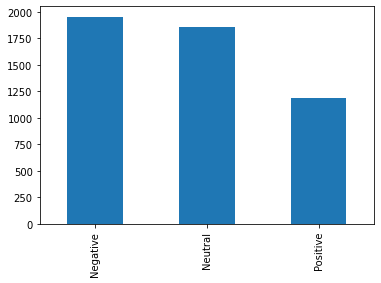

In [ ]:
df_orange['Sentiment'].value_counts().plot(kind='bar')